# EDA & Data Visualization
Because there are so many features in our loaning dataset, it's important to explore associations between them and identify the most significant factors contributing to default. In this notebook, univariate, bivariate, and multivariate analysis will be performed to understand the data better to build the model. 

### Imports

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/visualization") # access custom files

# import custom files
import plots

import os 
print(os.listdir("../data/LendingClub/processed"))

['Processed.csv']


### Loading and Inspecting Data
We have already cleaned parts of the raw data from LendingClub in the previous notebook, *Preprocessing.ipynb*, and we will use this version to create plots and look for interesting details about certain features. Some attributes like the loan *id*, and other unique features aren't very useful to inspect so they will be dropped from analysis.

In [3]:
processed_path = "../data/LendingClub/processed/Processed.csv"
data = pd.read_csv(processed_path)
print("Rows: " + str(data.shape[0]) + "  Columns: " + str(data.shape[1]))
data.head()

Rows: 143021  Columns: 150


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,159170615,NaN,16000.0,16000.0,16000.0,36 months,17.74%,576.36,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,159210254,NaN,10000.0,10000.0,10000.0,60 months,15.24%,239.17,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,159226028,NaN,15000.0,15000.0,15000.0,60 months,14.30%,351.37,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,159328733,NaN,24000.0,24000.0,24000.0,36 months,10.33%,778.14,B,B1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,159374118,NaN,15000.0,15000.0,15000.0,36 months,11.02%,491.23,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'debt_settlement_flag'],
      dtype='object', length=108)

### Loan Status
We should first explore the label we are trying to predict, which is the loan status detailing whether the loan is current, has been paid, is late, or has been charged off (default). Previously, we had encoded these categories into numerical values. The dictionary of encoding is referenced below, and we can see our data contains loans that fall into all of these categories.

In [29]:
status_dict = {0: "Charged Off", 1: "Current", 2: "Fully Paid", 3: "In Grace Period", 4: "Late (16-30 days)",
               5: "Late (31-120 days)"}

print(set(data["loan_status"]))
print(data["loan_status"].value_counts())

{0, 1, 2, 3, 4, 5}
1    134839
2      5929
5      1042
3       689
4       364
0       156
Name: loan_status, dtype: int64


We can make a barplot of counts for all the loan status outcomes. It appears we have loans falling into each of these categories. Now, we will dive deeper to understand what attributes of a loan contribute to this outcome.

(0, 148322.90000000002)

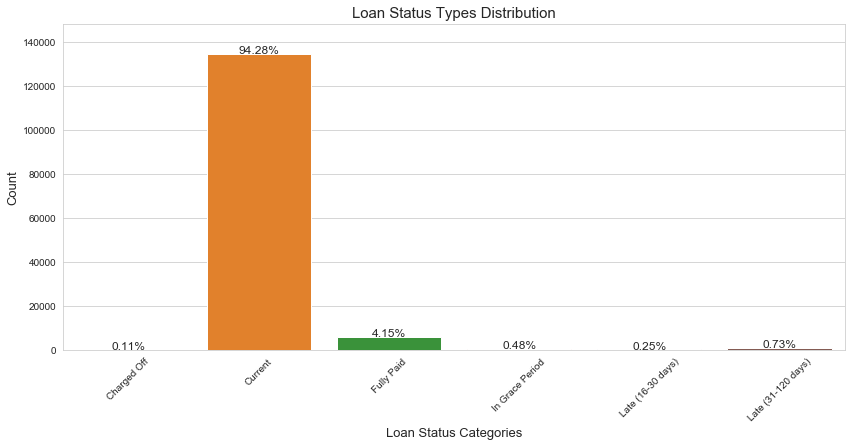

In [34]:
plt.figure(figsize=(14, 6))

g = sns.countplot(x="loan_status", data=data)
g.set_xticklabels(status_dict.values(), rotation=45)
g.set_xlabel("Loan Status Categories", fontsize=13)
g.set_ylabel("Count", fontsize=13)
g.set_title("Loan Status Types Distribution", fontsize=15)

proportions = []
for status in g.patches:
    height = status.get_height()
    proportions.append(height)
    g.text(status.get_x()+status.get_width()/2.,
            height + 3,
            "{:1.2f}%".format(height/len(data)*100),
            ha="center", fontsize=12) 

g.set_ylim(0, max(proportions)*1.1)

### Loan Amount
The loan amount requested is a good place to start, as understanding the distribution of loan amounts can give us a good idea of the range where most of the loans fall in. Large outliers may be much harder to pay back, which is probably a useful indicator of perdicting the loan status.

#### *Distribution*
To visualize the ranges of the loans, a histogram is helpful. It appears that most of the requested loans fall somewhere within the range of 0-40000 dollars, with various modes to consider; $10,000 still appears to be the most common loan amount. It can also be observed that most of these loans were funded by the lender by observing the distirbution of *funded_amnt*, which is the total amounts funded to the loan.

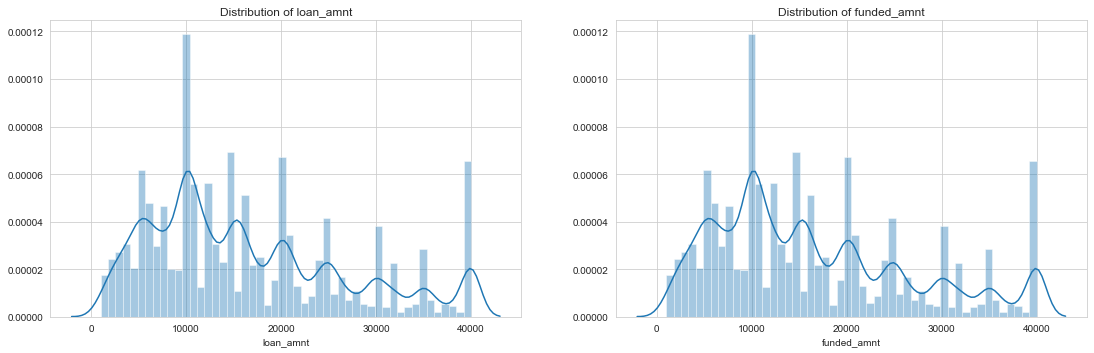

In [30]:
plt.figure()
fig = plt.gcf() #creates the plot figure object
fig.set_size_inches(16, 12) #sets the plot size
plt.subplot(2, 2, 1) #first subplot, 2 rows and 2 columns
plots.histogram("loan_amnt", data, kde=True)
plt.subplot(2, 2, 2) #second subplot, 2 rows and 2 columns
plots.histogram("funded_amnt", data, kde=True)
plt.subplots_adjust(left=0) #shift to make plots legible

#### *Grade*
It's also beneficial to understand the loan amounts in context with other features like the loan *grade*, which can provide insight to the total amounts requested by each grade, so we can detect outliers grade-wise.

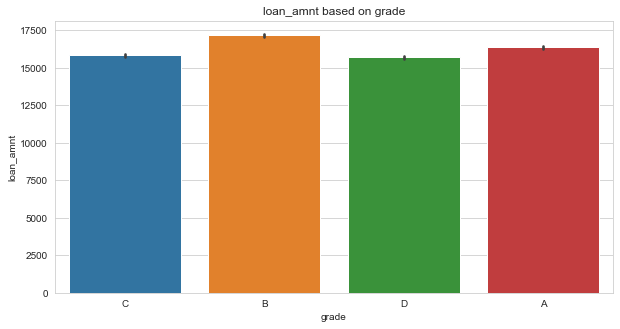

In [38]:
plt.figure()
fig = plt.gcf() #creates the plot figure object
fig.set_size_inches(10, 5) #sets the plot size
plots.barplot(data, "grade", "loan_amnt")

We can also observe the loan status for each of the grades as well by making *loan_status* a hue for our bar plot. This will display the amounts of loans that are ongoing, were fully paid, were fully charged off, etc.

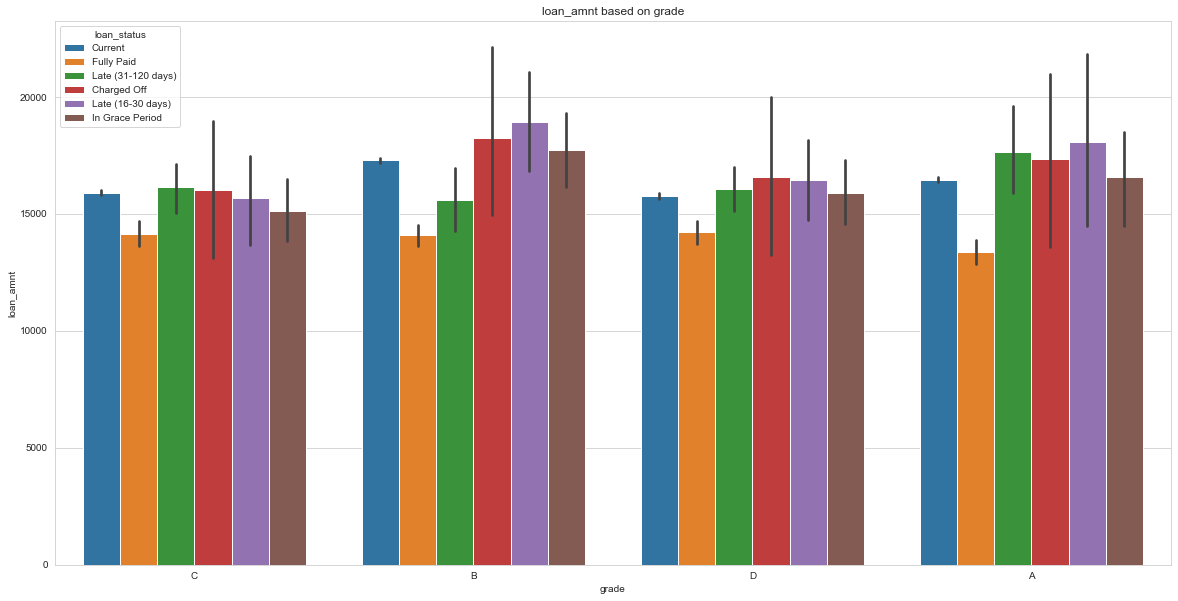

In [40]:
plt.figure()
fig = plt.gcf() #creates the plot figure object
fig.set_size_inches(20, 10) #sets the plot size
plots.barplot(data, "grade", "loan_amnt", hue="loan_status")

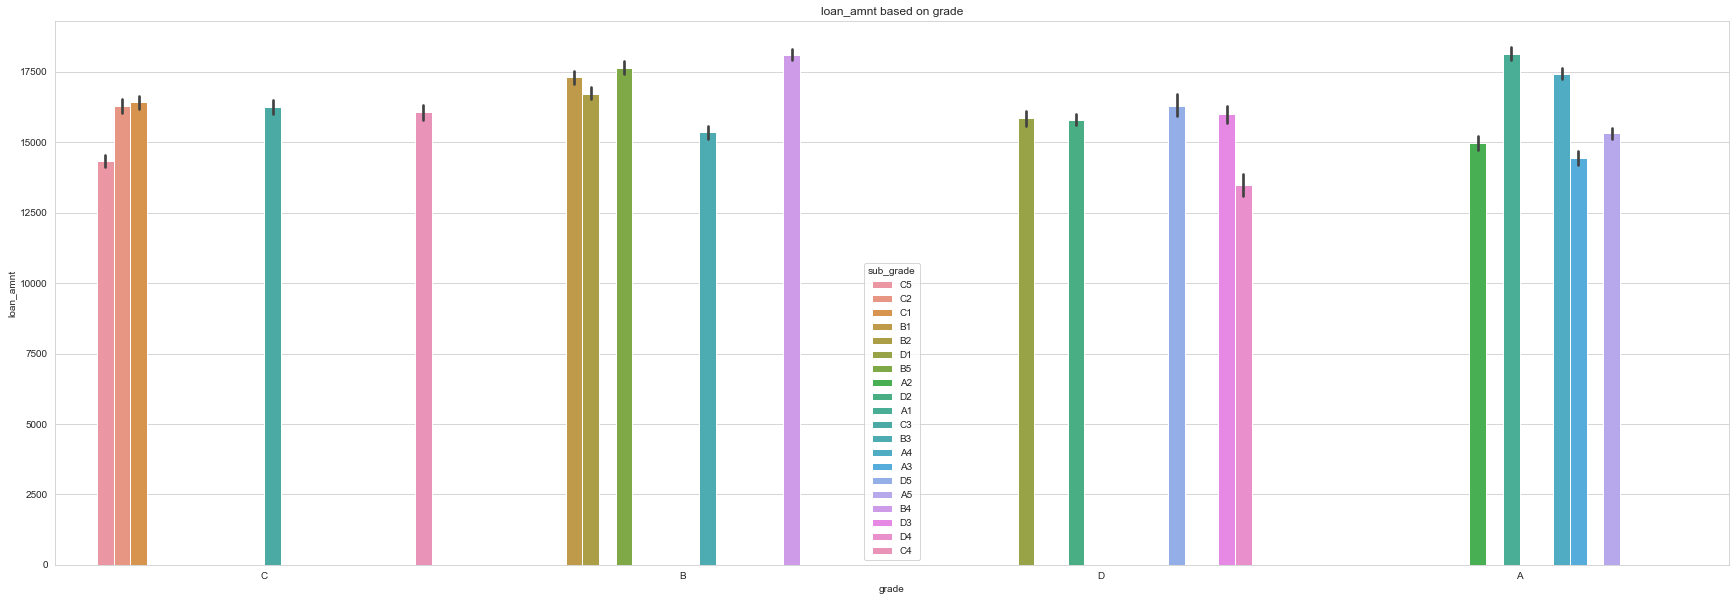

Text(0.5, 1, 'Loan Amount by Subgrade')

In [25]:
# Each grade also consists of a subgrade, so we can dive deeper into different loan categories
plt.figure()
fig = plt.gcf() 
fig.set_size_inches(30, 10)
g = plots.barplot(data, "grade", "loan_amnt", hue="sub_grade")
g.set_xlabel("Grade", fontsize=13)
g.set_ylabel("loan_amnt", fontsize=13)
g.set_title("Loan Amount by Subgrade", fontsize=15)

### Loan Purpose & Employment
It may be beneficial to understand the purposes for the loans in the data, since the use of the borrowed money may contribute to whether it is paid back or not. Some may borrow money for a new car, to pay off their house, or for other casual purposes. Others may need financing for debt consolidation, which is to pay off all their other current liabilities, or to finance a business. These activities seem to carry more risk and may have an impact on default.

#### *Loan Purpose*
We can observe the number of loans made for each type of purpose and understand what the majority of borrowers are looking to do. Some loan purposes may have higher risks and lead to more defaults, while other purposes may be easier to pay off.

(0, 85105.90000000001)

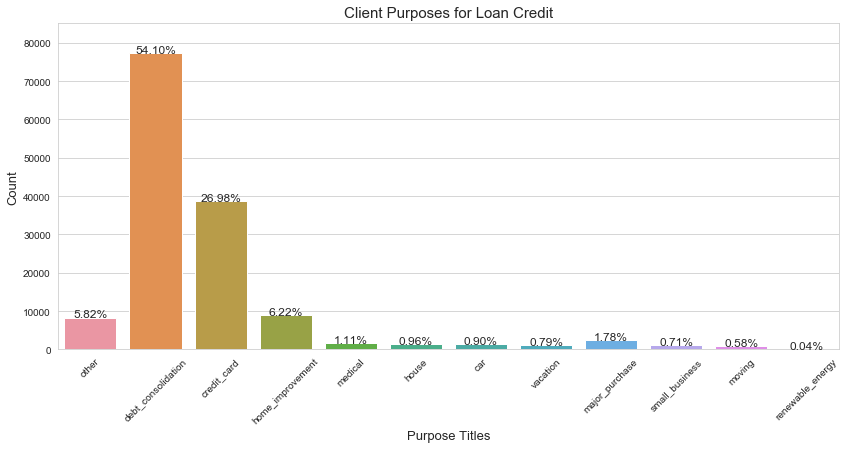

In [48]:
plt.figure(figsize=(14, 6))

g = sns.countplot(x='purpose', data=data)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("Purpose Titles", fontsize=13)
g.set_ylabel('Count', fontsize=13)
g.set_title("Client Purposes for Loan Credit", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(data)*100),
            ha="center", fontsize=12) 
    
g.set_ylim(0, max(sizes) * 1.1)

#### *Employment Title*
*IP*: Text processing/regular expressions

In [67]:
set(data["emp_title"])

{nan,
 'players club supervisor',
 'Veterinary Technitian',
 'Treatment Coordinator',
 'accounts payable',
 'Social Work',
 'AVP of Lending',
 'sr. bldg. custodian',
 'Eligibilty',
 'Maintenance custodian',
 'Director of Curriculum',
 'Administrative Assisitant',
 'Service Tech ',
 'Claim Adjuster ',
 'Front desk ',
 'Props coordinator ',
 'Cold storage ',
 'Real Estate Appraiser',
 'Project Manager/Estimator',
 'Nurse Assistant ',
 'SVP/ Regional Manager',
 'Supply Coordinator',
 'Resource Scheduler and Coordinator',
 'SCSR',
 'Producer ',
 'Zoology Technician ',
 'Sr. Staff Product Designer',
 'Therapeutic Couple',
 'Systems and Network Analyst',
 'wine sale man',
 'Maintenance worker',
 'Histotechnologist ',
 'Lab and X-ray Tec/Trainer',
 'Specialist Sr Communications ',
 'Director, State and Local Affairs',
 'Cafeteria Manager',
 'Secority Officer',
 'Assistant Project Manager',
 'Patient Services Manager ',
 'Vice President of Operations ',
 'Legislative Assistant II',
 'ENGINEER 

#### *Employment Length*
The amount of time that someone has been employed can reveal information about not only job stability, but also experience with managing finances and responsibility to repay loans. Longer employment length could mean that the borrower is more likely to pay off their debt since they have less risk of becoming unemploymed and a more organized financial plan than borrowers with less experience.

In [69]:
set(data["emp_length"])

{'1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year',
 nan}

### Loan Date
Loans are requested at different times throughout the year. However, some months may be more popular than others for a vareity of reasons which could have an impact to default. For example, there may be a time during the year where the economy performs poorly and people are in need of financing. The *issue_d* column contains data about the month in which the loan was funded, which will be very useful when joining our economy data with the lending data. For now, we sohuld understand which months and years are the most common for requesting a loan.

In [6]:
data["issue_d"].head()

0    Sep-2019
1    Sep-2019
2    Sep-2019
3    Sep-2019
4    Sep-2019
Name: issue_d, dtype: object

In [5]:
data["year"] = pd.to_datetime(data["issue_d"]).dt.year
data["month"] = pd.to_datetime(data["issue_d"]).dt.month

Text(0, 0.5, 'Number of Loans')

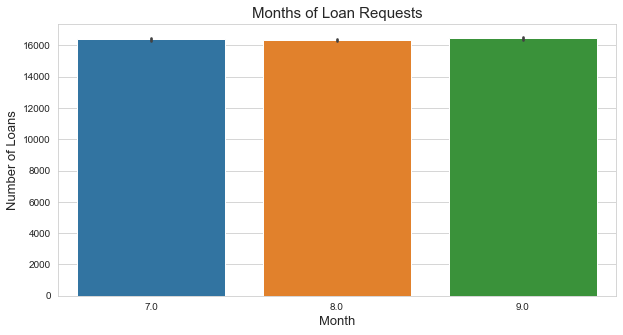

In [45]:
plt.figure(figsize=(10, 5))
sns.barplot('month', 'loan_amnt', data=data)
plt.title('Months of Loan Requests', fontsize=15)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Number of Loans', fontsize=13)

Similar to previous features explored, the *loan_status* can be be a hue for the bar plot that shows the total amount of loans ongoing, fully paid, charged off, etc... by month of the loan.

Text(0, 0.5, 'Number of Loans')

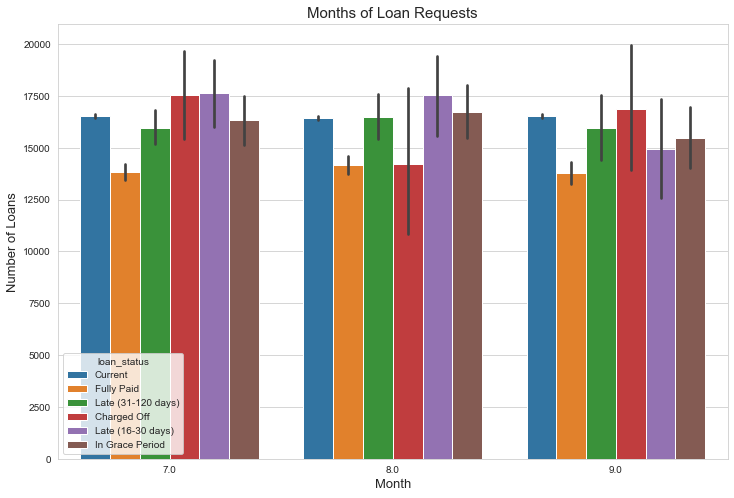

In [44]:
plt.figure(figsize=(12, 8))
sns.barplot('month', 'loan_amnt', data=data, hue="loan_status")
plt.title('Months of Loan Requests', fontsize=15)
plt.xlabel('Month', fontsize=13)
plt.ylabel('Number of Loans', fontsize=13)

In [ ]:
'''
plt.figure(figsize=(12, 8))
sns.barplot('year', 'loan_amnt', data=data)
plt.title('Years of Loan Requests', fontsize=15)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Loans', fontsize=13)
'''

It can be observed that some months and years have more requested loans than others, which may be helpful information when put into context of the macroeconomic condition. As shown in the plots where *loan_status* is an additional hue, there are varying amounts of loans that were charged off throughout these time periods. Some months and years have much more charged off loans than others, which is very interesting: the time of a loan seems to have an impact on its status. When there is a turndown and factors like unemployment rise, people may be inclined to attain financing for their activities, but may have difficulty paying back. This topic will explored in another notebook with the joined data, where we will evaluate the extent to which macroeconomic factors contribute towards default.

### Location
The address of the borrower is also a potential indicator for *loan_status* since different areas of the countries have varying economic conditions. For example, areas near the rust belt could have lower incomes and higher unemployment, while areas in California could be significantly wealthier. This feature is important when joining the macroeconomic data because states have varying macroecjonomic factors and the data will be joined by the corresponding location. For now, it's good to visualze and analyze which states had more charge offs than others, which could provide insight about locations with poorer economies, a potentially important factor to predicting the outcome of a loan.

In [63]:
data["addr_state"]

0          WY
1          WI
2          TX
3          MT
4          WI
         ... 
143016     CA
143017     CA
143018     IN
143019    NaN
143020    NaN
Name: addr_state, Length: 143021, dtype: object

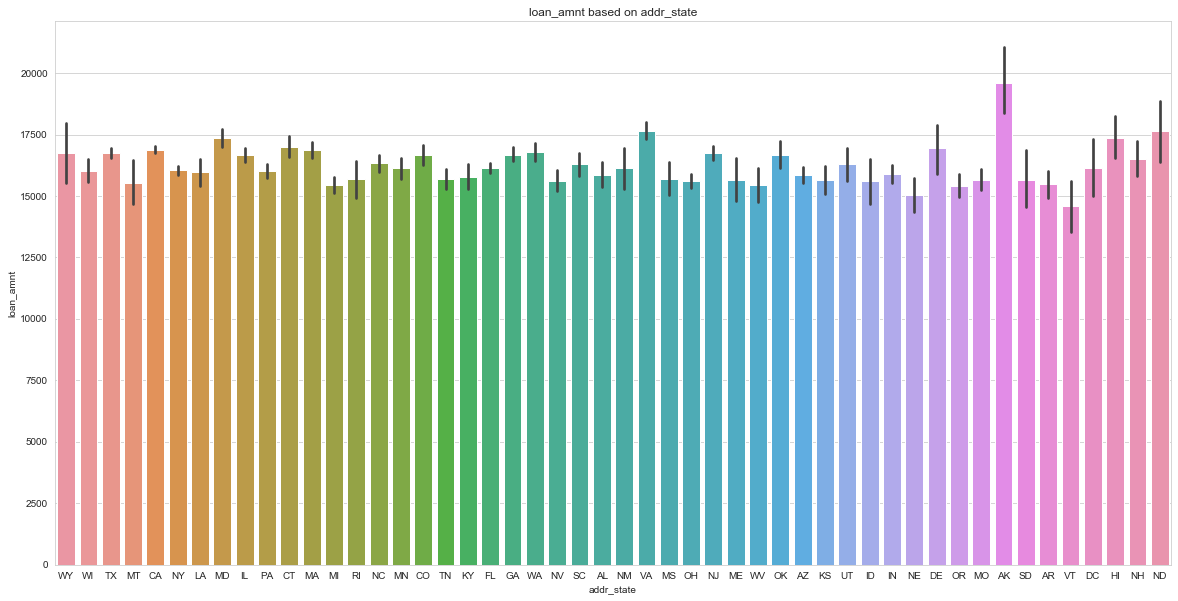

In [65]:
plt.figure()
fig = plt.gcf() #creates the plot figure object
fig.set_size_inches(20, 10) #sets the plot size
plots.barplot(data, "addr_state", "loan_amnt")

In [ ]:
# *In progress* making geospatial plot w/ plotly

### FICO Score (Credit Score)
One of the most fundamental indicators of a borrower's reliability to pay back their loan is their credit score. The FICO score is a trusted source of credit score determination and is evaluated when issuing loans. It will be useful to understand the distribution of FICO scores in the data which will be important in predicting the *loan_status*, as people with lower FICO scores are expected to have more charge offs.

The data contains two FICO score columns, one containing the highest score that the borrower had during the loan period, and the other containing the lowest score. To combine these scores, we can simply take the average of them since it is highly unlikely that someone's credit score will go from poor to excellent in the short-term duration of the loan.

In [55]:
data["fico_average"] = (data["fico_range_high"] + data["fico_range_low"])/2
data["fico_average"].head()

0    737.0
1    777.0
2    682.0
3    672.0
4    722.0
Name: fico_average, dtype: float64

Here is the distribution of FICO scores across the dataset for borrowers. It appears unimodal and skewed right, with more people in the data having scores around 700. This makes sense, as many people may need financing to pay off some debt or for other purposes, while those with very high credit scores (>800) are less likely in need of a loan.

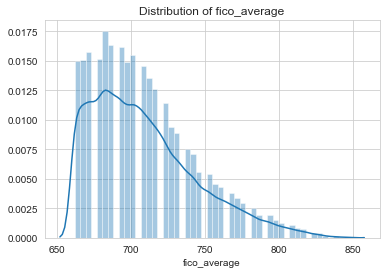

In [56]:
plots.histogram("fico_average", data, kde=True)

There has been a generally agreed upon distribution of FICO score ranges that fall into different categories of someone's credit. This range is used in the function below, where we can convert each borrower's FICO score to a category for better understanding and analysis of default.

In [57]:
def fico_rating(fico_score):
    """
    Converts raw FICO score to a categorical assessment of borrower's credit.
    
    :param fico_score: FICO score of borrower
    :returns: rating of FICO score
    """
    if 579 >= fico_score >= 300:
        return "Poor"
    elif 669 >= fico_score >= 580:
        return "Fair"
    elif 739 >= fico_score >= 670:
        return "Good"
    elif 799 >= fico_score >= 740:
        return "Very Good"
    elif fico_score >= 800:
        return "Exceptional"
    
    
data["fico_rating"] = data["fico_average"].apply(fico_rating)
data["fico_rating"].head()

0         Good
1    Very Good
2         Good
3         Good
4         Good
Name: fico_rating, dtype: object

Now we can visualize the loan amounts requested by each category of FICO scores, which will show whether borrowers with higher scores request more than lower scores. Furthermore, it's very useful to include a hue of loan status as well to understand if certain score categories had higher rates of charge offs when requesting larger amounts.

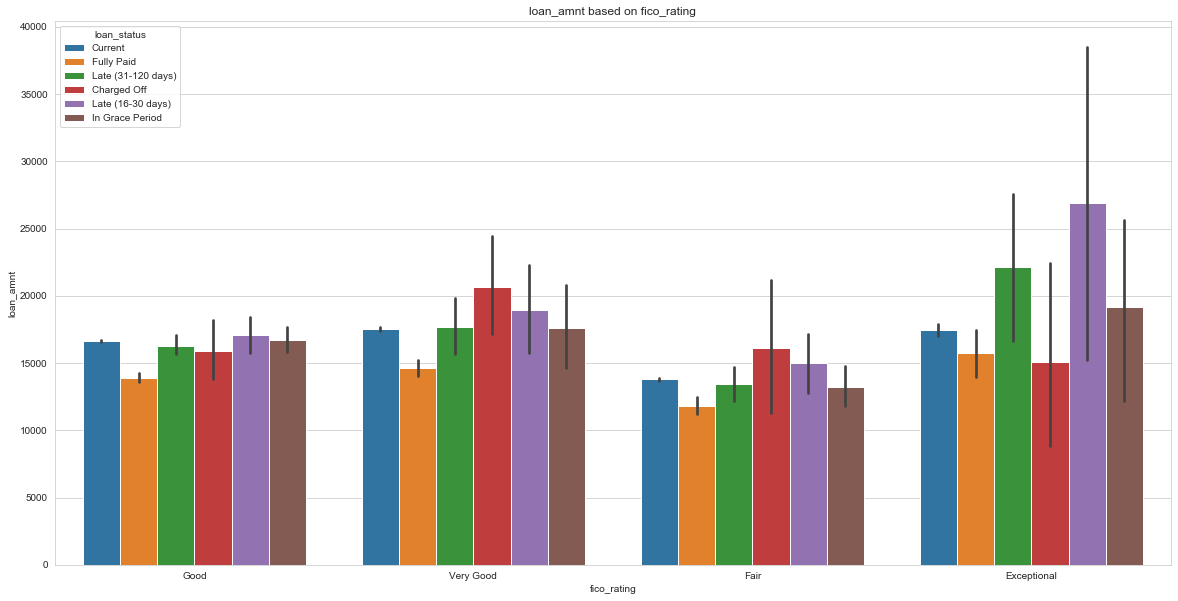

In [60]:
plt.figure()
fig = plt.gcf() 
fig.set_size_inches(20, 10)
plots.barplot(data, "fico_rating", "loan_amnt", hue="loan_status")